In [1]:
import os
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from d2l import torch as d2l

import warnings
warnings.filterwarnings('ignore')

In [2]:
d2l.DATA_HUB['pokemon'] = (
    d2l.DATA_URL + 'pokemon.zip',
    'c065c0e2593b8b161a2d7873e42418bf6a21106c'
)

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [3]:
batch_size = 256

transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

pokemon.transform = transformer

data_iter = torch.utils.data.DataLoader(
    pokemon, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4
)

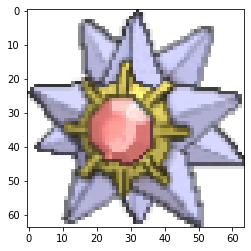

In [5]:
example = next(iter(data_iter))[0][0]

plt.imshow(example.permute(1, 2, 0) / 2 + 0.5)
plt.show()

# Generator

The generator consists of four basic blocks that increase input’s both width and height from 1 to 32.

In [7]:
class G_block(nn.Module):
    def __init__(
        self, 
        out_channels, 
        in_channels=3, 
        kernel_size=4, 
        strides=2,
        padding=1, 
        **kwargs):

        super(G_block, self).__init__(**kwargs)
        
        self.conv2d_trans = nn.ConvTranspose2d(
            in_channels, 
            out_channels,
            kernel_size, 
            strides, 
            padding,
            bias=False
        )
        
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))


In [9]:
n_G = 64

net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G * 8, strides=1,padding=0),  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G * 8,out_channels=n_G * 4),  # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G * 4,out_channels=n_G * 2),  # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G * 2, out_channels=n_G),  # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

In [10]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

# Discriminator

Is a normal convolutional network network except that it uses a leaky ReLU as its activation function.

A basic block with default settings will halve the width and height of the inputs

In [11]:
class D_block(nn.Module):
    def __init__(
        self, 
        out_channels, 
        in_channels=3, 
        kernel_size=4, 
        strides=2,
        padding=1, 
        alpha=0.2, 
        **kwargs):
        
        super(D_block, self).__init__(**kwargs)
        
        self.conv2d = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size,
            strides, padding,
            bias=False
        )
        
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [12]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D * 2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D * 2, out_channels=n_D * 4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D * 4, out_channels=n_D * 8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D * 8, out_channels=1, kernel_size=4, bias=False)
)

In [13]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

In [18]:
from tqdm import tqdm

def train(
    net_D, 
    net_G, 
    data_iter, 
    num_epochs, 
    lr, 
    latent_dim,
    device=d2l.try_gpu()):
    
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    
    net_D, net_G = net_D.to(device), net_G.to(device)
    
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)

    for epoch in tqdm(range(1, num_epochs + 1)):

        for X, _ in tqdm(data_iter):
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            d2l.update_D(X, Z, net_D, net_G, loss, trainer_D)
            d2l.update_G(Z, net_D, net_G, loss, trainer_G)